In [ ]:
# default_exp features

In [1]:
#hide
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Features


> This module contains all the necessary functions for extracting and organizing features from videos.

In [12]:
#export
import cv2
import ffmpeg

import torch

import numpy as np

from abc import ABC, abstractmethod

from fastprogress.fastprogress import progress_bar

# tango
from tango.prep import *

from tango.cnn import *

from pathlib import Path

from PIL import Image

from matplotlib import pyplot as plt

from nbdev.showdoc import *

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
path = Path("/tf/data/datasets/videos")
video_paths = sorted(path.glob("**/video.mp4")); video_paths[:6]

[PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/ibis_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4'),
 PosixPath('/tf/data/datasets/videos/auto_and_vehicles/car_part/scenario2/video.mp4')]

In [11]:
rico_path = Path('/tf/data/combined/data')
img_paths = sorted(rico_path.glob('*.jpg'))
len(img_paths), img_paths[:5]

(66261,
 [PosixPath('/tf/data/combined/data/0.jpg'),
  PosixPath('/tf/data/combined/data/1.jpg'),
  PosixPath('/tf/data/combined/data/10.jpg'),
  PosixPath('/tf/data/combined/data/100.jpg'),
  PosixPath('/tf/data/combined/data/1000.jpg')])

In [21]:
from random import sample

n = 10_000
sampled_imgs = [np.array(Image.open(img)) for img in sample(img_paths, n)]
len(sampled_imgs)

10000

In [22]:
#export
class Extractor(ABC):

    def __init__(self, extractor):
        self.extractor = extractor
        super().__init__()
    
    @abstractmethod
    def extract(self, img):
        pass

In [23]:
#export
class SIFTExtractor(Extractor):
    
    '''Exposed SIFTExtractor class used for retrieving features.'''

    def extract(self, img):
        '''Given an image, extract features using SIFT. Returns the feature vector.'''
        _, features = self.extractor.detectAndCompute(img, None)
        return features
    
class CNNExtractor(Extractor):
   
    '''Exposed CNNExtractor class used for retrieving features.'''

    def extract(self, img):
        '''Given an image, extract features from the layers of a CNN. Returns the feature vector.'''
        
        return self.extractor.getFeatures(img)

In [17]:
imgs = get_rand_imgs(video_paths[0], 30_000, n = 100)

In [18]:
#Three different extraction techniques
# learn, linear_output_layer = trainPetsModel()
# extractor = CNNExtractor(cnn.createExtractor(learn, linear_output_layer, 'resnet50', True))
extractor = CNNExtractor(createExtractor(None, None, 'resnet50', False))
# extractor = CNNExtractor(cnn.createLayeredExtractor())

In [24]:
sampled_imgs[0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
      

In [26]:
#Using the extractor to extract the feature vector
features = extractor.extract(sampled_imgs[0])

In [28]:
#export
def gen_vcodebook(imgs, extractor, vwords = 10_000):
    """
        Constructs a visual codebook based on the given images.
        You can change vwords to increase the vocabulary of the codebook.
    """
    features_list = []
    for img in imgs:
        features = extractor.extract(img)
        features_list.extend(features)
    
    codebook = KMeans(n_clusters = vwords)
    codebook.fit(features_list)
    
    return codebook

In [ ]:
vwords = 1_000
codebook = gen_vcodebook(sampled_imgs, extractor, vwords)

In [ ]:
fname = f'/tf/data/models/cookbook_{len(sampled_imgs)}n_{vwords}vw.model'
pickle.dump(codebook, open(fname, 'wb'))

# load the model from disk
# codebook = pickle.load(open(fname, 'rb'))

<BarContainer object of 20 artists>

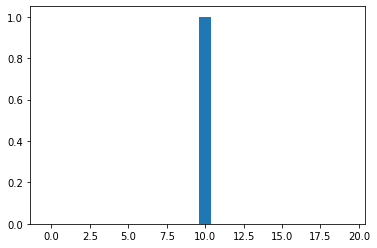

In [ ]:
#hide
labels = codebook.predict(features)
hist = np.histogram(labels, bins = vwords)
plt.bar(range(vwords), hist[0])

In [ ]:
#export
def get_df(imgs, extractor, codebook, vwords):
    """Generates the document frequency for the visual words"""
    hist = None
    for img in imgs:
        features = extractor.extract(img);
        vw = codebook.predict(features)
        if hist is not None:
            hist += np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
        else:
            hist = np.clip(np.histogram(vw, bins = vwords)[0], 0, 1)
    
    return hist

In [ ]:
df = get_df(imgs, extractor, codebook, vwords)

In [ ]:
#hide
df

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0,   0,   0,   0,   0,   0,   0])

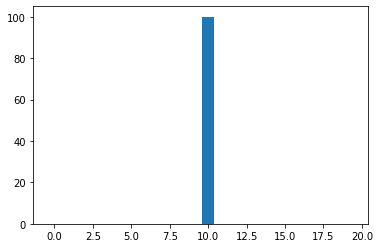

In [ ]:
#hide
plt.bar(range(vwords), df)
plt.show()

In [ ]:
#export
def get_bovw(vid_path, extractor, codebook, vwords, n = None):
    """Generates the bag of visual words (bovw) for an entire video."""
    vid = cv2.VideoCapture(str(vid_path))
    if n is None: n = vid.get(cv2.CAP_PROP_FRAME_COUNT)
    
    # checks whether frames were extracted 
    success = 1
    bovw = np.array([])
    for i in progress_bar(range(n)):
        # vid object calls read 
        # function extract frames 
        success, img = vid.read() 
        if success:
            features = extractor.extract(img)
            vw = codebook.predict(features)
            bovw = np.concatenate((bovw, vw))
    
    hist = np.histogram(bovw, bins = vwords)[0]
    return hist, bovw

In [ ]:
#export
def new_get_bovw(vid, extractor, codebook, vwords, fps = 30, frames_to_keep = 1):
    bovw = []
    for i in range(0, len(vid), int(fps / frames_to_keep)):
        features = extractor.extract(vid[i])
        vw = codebook.predict(features)
        bovw.extend(vw)
    
    bovw = np.array(bovw)
    hist = np.histogram(bovw, bins = vwords)[0]
    return hist, bovw
#         bovw = np.concatenate((bovw, vw))

In [ ]:
vid = Video(video_paths[3])
hist, bovw = new_get_bovw(vid, extractor, codebook, vwords, frames_to_keep = 2)

In [ ]:
len(bovw)

26

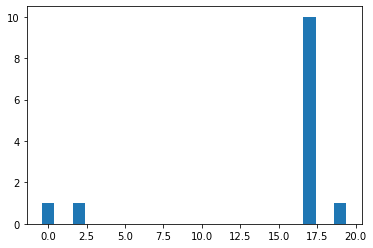

array([ 1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 10,  0,  1])

In [ ]:
#hide
plt.bar(range(vwords), hist)
plt.show()
hist

In [ ]:
#export
def calc_tf_idf(tfs, dfs):
    tf_idf = np.array([])
    for tf, df in zip(tfs, dfs):
        tf = tf / np.sum(tfs)
        idf = np.log(len(tfs) / (df + 1))
        tf_idf = np.append(tf_idf, tf * idf)
    
    return tf_idf

In [ ]:
tf_idf_pix2 = calc_tf_idf(hist, df)

In [ ]:
#hide
hist2, bovw2 = get_bovw(video_paths[2], extractor, codebook)
tf_idf_pix1 = calc_tf_idf(hist2, df)

In [ ]:
#hide
hist3, bovw3 = get_bovw(video_paths[4], extractor, codebook)
tf_idf_car1 = calc_tf_idf(hist3, df)

In [ ]:
#hide
hist4, bow4 = get_bovw(video_paths[5], extractor, codebook)
tf_idf_car2 = calc_tf_idf(hist4, df)

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix2) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix2))

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car2) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car2))

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_car1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_car1))

In [ ]:
#hide
np.dot(tf_idf_pix2, tf_idf_car2) / (np.linalg.norm(tf_idf_pix2) * np.linalg.norm(tf_idf_car2))

In [ ]:
#hide
np.dot(tf_idf_pix1, tf_idf_pix1) / (np.linalg.norm(tf_idf_pix1) * np.linalg.norm(tf_idf_pix1))

In [ ]:
#hide
np.dot(tf_idf_car1, tf_idf_car1) / (np.linalg.norm(tf_idf_car1) * np.linalg.norm(tf_idf_car1))

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario2/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/art_and_design/pixel_art_paint/scenario1/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
%%HTML
<video width="420" height="315" controls autoplay>
    <source src="../../data/datasets/videos/auto_and_vehicles/car_part/scenario1/video.mp4" type="video/mp4"/>
</video>

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_prep.ipynb.
Converted 01_features.ipynb.
Converted 02_eval.ipynb.
Converted 03_cnn.ipynb.
Converted 04_experiments.ipynb.
Converted index.ipynb.
Converted lesson1-pets.ipynb.
